In [1]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import pandas as pd



In [2]:
# ====         1. Ocean Heat Content (OHC) CLIMATOLOGY AND ANOMALIES   ======
## Open the ECCO grid files
grid_dir  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')
ds_grid   = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

## Open the monthly temperature-salinity files
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))

## Organise temperature data into 12 (month) folders, each of them containing OHC throughout 1992-2019:
T         = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##loops throughout the 336 monthly files 1992-2019
    ds        = xr.open_dataset(file_path)
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    temp      = ds.THETA
    T[month_idx].append(temp)
depth_names   = T[0][0].Z.values ## extract the depths from a random temperature file
##set some constants
rho       = 1025  # kg/m³
cp        = 3985   # J/(kg·°C)
deep      = 6;shallow = 0 ##choose indices of the lowest and upper depth of the water column to be examined
##construct the thickness of
upper     = ds_grid.Zu;bottom = ds_grid.Zl
dz        = bottom - upper;
dz_1d     = xr.DataArray([dz.isel(k_l=i, k_u=i).values for i in range(dz.sizes['k_l'])], dims=['k'])
dz_layer  = dz_1d.isel(k=slice(shallow, deep))  # select the dz values for the vertical slice

## ------ Calculate the 2D Monthly OHC ---------
tile        = 0 ### choose the tile over which to calculate the OHC timeseries 
OHC_monthly = [[] for _ in range(12)]  # Store one 3D field per month-year
for month in range(12):
    for temp in T[month]:  # each `temp` is one DataArray (tile, k, j, i)
        temp_layer        = temp[0].isel(k=slice(shallow, deep))  # select k=0 to 6
        dz_layer_reshaped = dz_layer.broadcast_like(temp_layer)
        ohc               = (temp_layer * dz_layer_reshaped).sum(dim="k")  # °C·m
        ohc               = ohc * rho * cp  # Convert to J/m²
        OHC_monthly[month].append(ohc)

# -- -- -- -- 2D Monthly OHC anomalies -- -- -- -- 
#a list of 12 xarray DataArrays, one per month, each with dimensions (year, tile, j, i)
OHC_monthly_stacked = [xr.concat(month_data, dim="year") for month_data in OHC_monthly]
#a list of 12 DataArrays, one per month, each with dimensions (tile, j, i)
OHC_climatology     = [monthly.mean(dim="year") for monthly in OHC_monthly_stacked]
OHC_anomalies       = [monthly - climatology for monthly, climatology in zip(OHC_monthly_stacked, OHC_climatology)]

## -- -- -- -- MONTHLY OHC Timeseries -- -- -- -- 
TMSROHC        = [] ## Store timeseries
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops through
    ds         = xr.open_dataset(file_path);
    temp       = ds.THETA
    temp_layer = temp[0].isel(k=slice(shallow, deep))  # select k=0 to 6
    dz_layer_reshaped = dz_layer.broadcast_like(temp_layer)
    ohc        = (temp_layer * dz_layer_reshaped).sum(dim="k")  # °C·m
    ohc        = ohc * rho * cp  # Convert to J/m²
    ohc_fin    = ohc[tile,:,:].mean(dim=["j","i"],skipna=True)
    TMSROHC.append(ohc_fin)


In [5]:
##2. Calculate the Monthly Anomalous OHC Timeseries  -- -- -- -- 
TMSROHC_da          = xr.concat(TMSROHC, dim='time')
start_date          = pd.to_datetime(str(TMSROHC_da.time.values[0]))
dates               = pd.date_range(start = start_date, periods=TMSROHC_da.sizes['time'], freq='MS')
ts_pd               = pd.Series(TMSROHC_da.values, index=dates, name='ts_x')
monthly_clim        = ts_pd.groupby(ts_pd.index.month).mean()# 3. Now group by calendar month and compute the climatology:
# Make the 12-month climatology to full length:
n_months            = len(ts_pd)
n_repeats           = n_months // 12
clim_full           = np.tile(monthly_clim.values, n_repeats)
# Re-wrap into a Series aligned with your dates
clim_full_series    = pd.Series(clim_full, index=ts_pd.index, name='Climatology')
# now calculat the monthly anomalous OHC Timeseries 
anomalies           = ts_pd - clim_full_series



In [9]:
###3. Extract the anomalous OHC Timeseries of winter MHW period: June 2002-December 2003
ystart, yfin = 1992, 2020
nyears       = yfin - ystart
nmonths      = nyears * 12
# Create monthly date index Jan 1992 – Dec 2019
dates        = pd.date_range(start=f'{ystart}-01-01', periods=nmonths, freq='MS')
# Example anomaly array (replace with your real data)
anomalies    = TMSROHC_da.values  # length = nmonths
# Year ticks/labels for full plot
year_ticks   = list(range(0, nmonths, 12))
year_labels  = [str(y) for y in range(ystart, yfin)]
# Zoom window: June 2002 – December 2003
start_ev     = 2002
fin_ev       = 2003
start_idx    = (start_ev - ystart) * 12                   # Jan 2002 index
end_idx      = (fin_ev   - ystart) * 12 + 11               # Dec 2003 index
zoom_idx     = list(range(start_idx, end_idx + 1))
# Identify all JJA months (June, July, August) across full record
jja_mask     = (dates.month >= 6) & (dates.month <= 8)
jja_idx      = np.where(jja_mask)[0]
# Identify JJA 2002 specifically
jja2002_idx  = np.where((dates.year == 2002) & (dates.month >= 6) & (dates.month <= 8))[0]

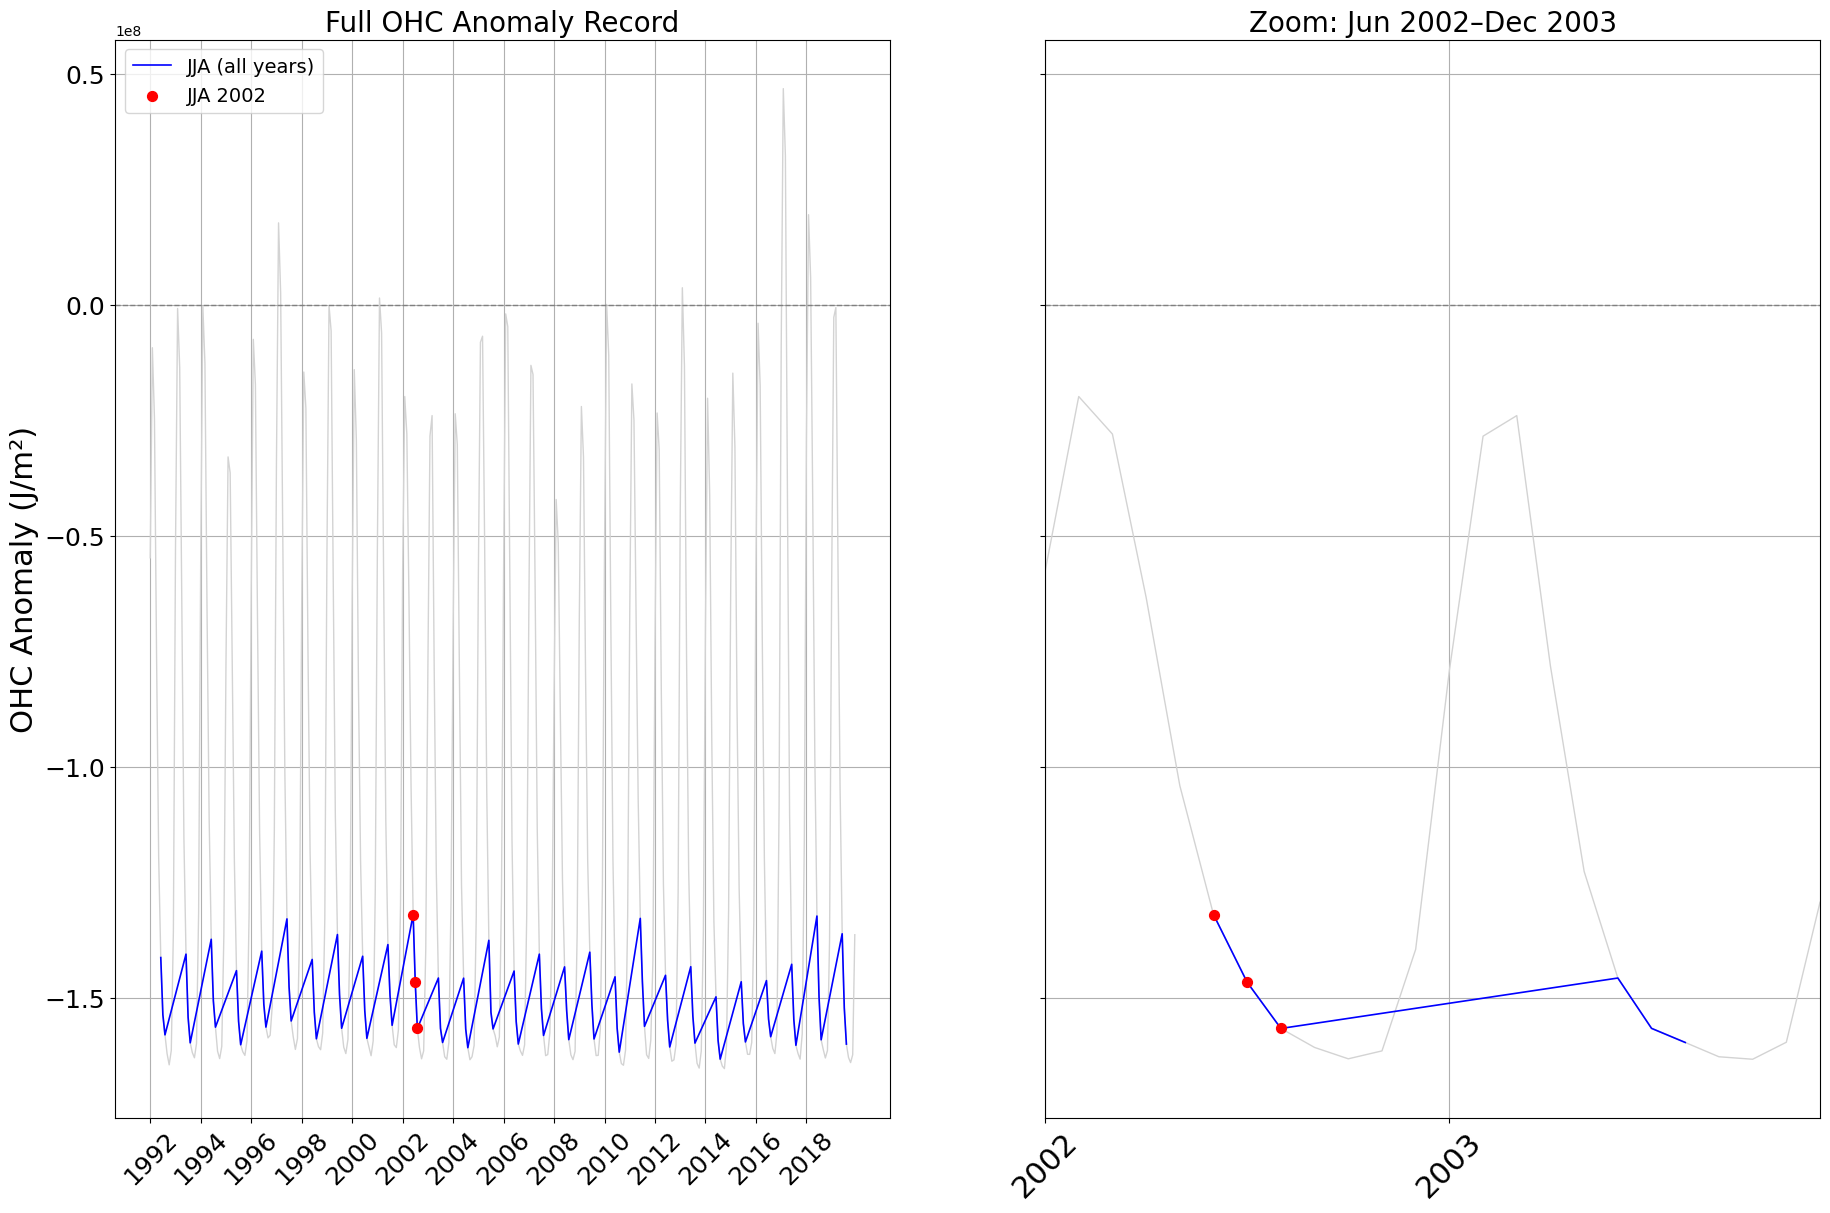

In [8]:
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
mon       = 6
tile      = 12
# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(22, 14), sharey=True)
ax = axes[0]
# grey full series
ax.plot(range(nmonths), anomalies, color='lightgrey', linewidth=1)
# blue JJA line
ax.plot(jja_idx, anomalies[jja_idx], color='blue', linewidth=1.2, label='JJA (all years)')
# red dots for JJA 2002
ax.scatter(jja2002_idx, anomalies[jja2002_idx], color='red', s=50, zorder=5, label='JJA 2002')
# formatting
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xticks(year_ticks[::2])
ax.set_xticklabels(year_labels[::2], rotation=45, fontsize=16)
ax.set_title('Full OHC Anomaly Record', fontsize=20)
ax.set_ylabel('OHC Anomaly (J/m²)', fontsize=22)
ax.grid(True)
ax.legend(fontsize=14)
ax.tick_params(axis='both', labelsize=18)
# 2) ZOOM: June 2002 – Dec 2003
ax   = axes[1]
ax.plot(zoom_idx, anomalies[zoom_idx], color='lightgrey', linewidth=1)
zoom_jja     = [i for i in jja_idx if i in zoom_idx]
ax.plot(zoom_jja, anomalies[zoom_jja], color='blue', linewidth=1.2)
zoom_jja2002 = [i for i in jja2002_idx if i in zoom_idx]
ax.scatter(zoom_jja2002, anomalies[zoom_jja2002], color='red', s=50, zorder=5)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlim(zoom_idx[0], zoom_idx[-1])
ax.set_xticks([zoom_idx[0], zoom_idx[0] + 12])
ax.set_xticklabels([str(start_ev), str(start_ev + 1)], rotation=45, fontsize=16)
ax.set_title('Zoom: Jun 2002–Dec 2003', fontsize=20)
ax.grid(True)
ax.tick_params(axis='both', labelsize=22)
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/FINAL_FIG/WINTER_MHW_OHC_TMSR_ANOMALIES_TILE{tile}_{montitles[mon]}_{fin_ev}_{depth_names[shallow]}m_{depth_names[deep]}m.png')